# Introduction

In this notebook, we work on the **Predict Future Sales** competition on Kaggle.  
The goal is to forecast the total number of items sold in every shop for the next month.  
Specifically, we predict `item_cnt_month` for each `(shop_id, item_id)` pair in the test set (month 34).

This is essentially a time series forecasting problem, but with a twist: instead of a single sequence, we have thousands of parallel series (one per shop–item pair).  
That makes it more complex than a standard time series: we must capture both individual patterns (e.g., certain products sell better in specific shops) and global trends (e.g., seasonality, price effects, category shifts).


## Business Relevance

From a business perspective, this problem is highly relevant to retail and e-commerce:

- Accurate forecasts help manage inventory and reduce overstock/stockouts.  
- Better demand visibility supports supply-chain planning and store replenishment.  
- Understanding sales dynamics enables promotion strategy, pricing, and assortment decisions.  


## Pipeline

We follow a structured pipeline:

1. **Data Cleaning & Preprocessing** – prepare raw daily sales.  
2. **Aggregation** – convert to monthly sales at the shop–item level (the prediction target).  
3. **Feature Engineering** – build predictive signals: lags, rolling means, price dynamics, calendar features.  
4. **Model Training** – train LightGBM on months 0–32, validate on month 33.  
5. **Prediction & Submission** – forecast month 34 and export a Kaggle-ready submission.  


## Outcome

By the end, we have a working ML pipeline that forecasts shop–item sales one month ahead, balancing **statistical accuracy** and **business interpretability**.

# Predict Future Sales – Machine Learning Pipeline

## Step 0. Setup

**Explanation**  
Before starting the analysis, we need to import the required libraries:
- **pandas** and **numpy** → for data manipulation.  
- **matplotlib** → for visualization.
- **seaborn** → for visualization.
- **RandomForestRegressor** (from scikit-learn): baseline tree-based ensemble model.  
- **LGBMRegressor** (from LightGBM): gradient boosting model optimized for speed and performance, suitable for tabular data.  
- **mean_squared_error** (from scikit-learn): metric to evaluate regression performance.  
- **warnings**: utility to suppress warning messages for cleaner notebook output.  

In [25]:
!pip install lightgbm

In [1]:
# STEP 0: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor  
from sklearn.metrics import mean_squared_error

# Utils

import warnings
warnings.filterwarnings("ignore")

## Step 1. Load raw data

**Explanation**  
The dataset contains several CSV files:
- `sales_train.csv`: daily transactions with item price, item count, shop, and date.  
- `items.csv`: metadata about items.  
- `shops.csv`: metadata about shops.  
- `item_categories.csv`: metadata about categories.  
- `test.csv`: the test set, containing shop–item pairs for the next month (month 34).  

We load them into memory using **pandas**

In [5]:
# STEP 1: Load data

sales = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\sales_train.csv")
items = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\items.csv")
item_cats = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\item_categories.csv")
shops = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\shops.csv")
test = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\test.csv")

In [7]:
# Check data

print("Sales Data:", sales.shape)
print("Items:", items.shape)
print("Categories:", item_cats.shape)
print("Shops:", shops.shape)
print("Test Set:", test.shape)

Sales Data: (2935849, 6)
Items: (22170, 3)
Categories: (84, 2)
Shops: (60, 2)
Test Set: (214200, 3)


In [9]:
# Check table

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
# Check data structure

sales.info()
sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
# Focus on two key columns:
# item_price (price per transaction)
# item_cnt_day (items sold per day)

In [15]:
# Check min and max values

print("Min price:", sales['item_price'].min())
print("Max price:", sales['item_price'].max())
print("Min item count:", sales['item_cnt_day'].min())
print("Max item count:", sales['item_cnt_day'].max())

Min price: -1.0
Max price: 307980.0
Min item count: -22.0
Max item count: 2169.0


## Step 2. Data Cleaning

**Explanation**  
We need to clean the transactional data to remove invalid and unrealistic values.  

Rules applied:
- Remove rows where `item_price <= 0`.  
- Remove rows where `item_cnt_day < 0`.  
- Remove rows where `item_cnt_day > 1000`.  
- *(Optional)* Remove rows where `item_price > 100000` (unrealistic outliers).  

In [17]:
# STEP 2: Data cleaning
# Remove negative prices

sales = sales[sales['item_price'] < 0]

In [19]:
# Remove extreme outliers in item price (over 100,000 looks unrealistic)

sales = sales[sales['item_price'] > 100000]

In [21]:
# Remove extreme outliers in item count

sales = sales[(sales['item_cnt_day'] < 0) & (sales['item_cnt_day'] > 1000)]

## Step 3. Aggregate to monthly level
**Explanation**  
The Kaggle competition asks us to predict `item_cnt_month` (the number of items sold in a given month per shop–item pair).  
Since the training data is daily, we need to aggregate it into monthly counts.  

We group by:
- `date_block_num` (month index from 0 → 33)  
- `shop_id`  
- `item_id`  

Then we calculate:
- `item_cnt_month` → sum of all daily counts.  
- `item_price` → average price in that month.  


In [23]:
# STEP 3: Convert Daily Sales to Monthly Sales
# Aggregate daily sales into monthly totals

monthly_data = sales.groupby(
    ['date_block_num', 'shop_id', 'item_id']
).agg({
    'item_cnt_day': 'sum',     # total sales quantity per month
    'item_price': 'mean'       # average price in that month
}).reset_index()

In [24]:
# Rename column for clarity

monthly_data.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

## Step 4. Merge Metadata

**Explanation**  
Items belong to categories, and categories may capture trends (e.g., video games, books, etc.).  
Shops also provide useful signals (e.g., different sales patterns per region).  
Merging metadata tables enriches the training dataset with additional information.  

We perform three merges:
1. Merge with `items` table to get item details.  
2. Merge with `shops` table to add shop information.  
3. Merge with `item_categories` table to attach the `item_category_id`.  


In [27]:
# STEP 4: Merge Additional Information

# Merge with item info
df_final = pd.merge(monthly_data, items, on='item_id', how='left')

# Merge with shop info
df_final = pd.merge(df_final, shops, on='shop_id', how='left')

# Merge with item categories
df_final = pd.merge(df_final, item_cats, on='item_category_id', how='left')

In [29]:
df_final.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_name,item_category_id,shop_name,item_category_name
0,0,0,32,6.0,221.0,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
1,0,0,33,3.0,347.0,1+1 (BD),37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray
2,0,0,35,1.0,247.0,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
3,0,0,43,1.0,221.0,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
4,0,0,51,2.0,128.5,100 лучших произведений классики (mp3-CD) (Dig...,57,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3


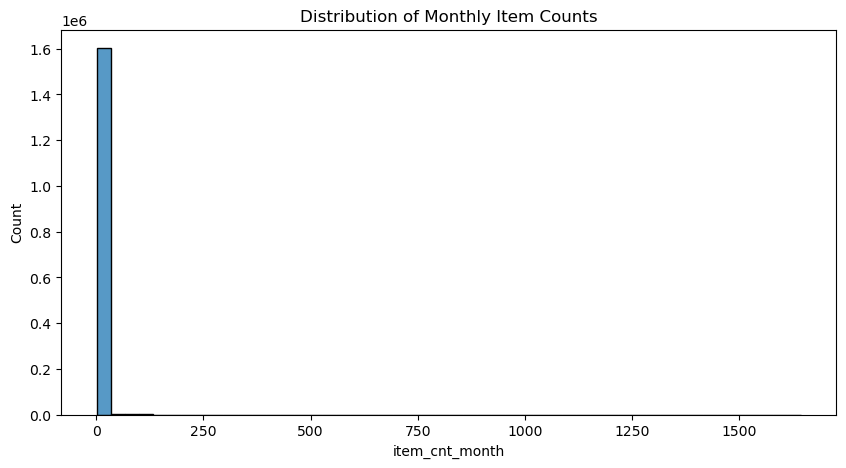

In [31]:
# STEP 5: Basic EDA

plt.figure(figsize=(10,5))
sns.histplot(df_final['item_cnt_month'], bins=50, kde=False)
plt.title('Distribution of Monthly Item Counts')
plt.show()

In [33]:
# Optional: Remove extreme outliers in monthly item counts

df_final['item_cnt_month'] = df_final['item_cnt_month'].clip(0, 20)

## Step 6. Feature Engineering
**Explanation**  
Machine learning models perform better when we provide additional features that describe past trends.  

We create:
- **Month and year features**: derived from `date_block_num`.  
- **Lag features**: previous month(s) sales (`lag_1`, `lag_2`, `lag_3`, `lag_6`, `lag_12`) for each shop–item. These capture seasonality and momentum.  
- **Rolling averages**: e.g. 3-month rolling mean of sales.  
- **Price features**: average price per item across time, and difference between current price and long-term average.  

We fill missing values with `0` because not every item is sold in every month.

In [35]:
# Step 6: Feature Engineering
# Sort

df_final = df_final.sort_values(['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

In [37]:
# Lag features

for lag in [1, 2, 3, 6, 12]:
    df_final[f'item_cnt_lag_{lag}'] = df_final.groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)

In [39]:
# Rolling mean

df_final['item_cnt_rolling_3'] = (
    df_final.groupby(['shop_id','item_id'])['item_cnt_month']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

In [41]:
# Price features

df_final['item_price_avg'] = df_final.groupby('item_id')['item_price'].transform('mean')
df_final['price_diff'] = df_final['item_price'] - df_final['item_price_avg']

In [43]:
# Time features

df_final['month'] = df_final['date_block_num'] % 12
df_final['year']  = df_final['date_block_num'] // 12 + 2013

In [45]:
# Encode categories

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['item_category_label'] = le.fit_transform(df_final['item_category_name'].astype(str))

In [47]:
# Fill NaNs

lag_cols = [f'item_cnt_lag_{lag}' for lag in [1, 2, 3, 6, 12]]
df_final[lag_cols] = df_final[lag_cols].fillna(0)
df_final['is_new_item'] = (df_final['item_cnt_lag_1'] == 0).astype('int8')

In [49]:
# Downcast types

df_final['item_cnt_month'] = df_final['item_cnt_month'].astype('float32')
for c in ['shop_id','item_id','item_category_id','date_block_num','month','year']:
    df_final[c] = pd.to_numeric(df_final[c], downcast='integer')

In [51]:
# Save checkpoint

df_final.to_csv('df_final_features.csv', index=False)

## Step 7. Train/Validation split
**Explanation**  
Because this is a time series problem, we must split the data based on **time**, not randomly.  
- **Training set** → months `0–32`.  
- **Validation set** → month `33`.  

This simulates the competition setting, where we predict **month 34** based on past data.  


In [53]:
# STEP 7: Prepare train/test split
# choose target and split points

TARGET = 'item_cnt_month'

# Feature columns

drop_cols = [TARGET, 'item_name', 'shop_name', 'item_category_name']  
feature_cols = [c for c in df_final.columns if c not in drop_cols]

In [55]:
# Split

train_mask = df_final['date_block_num'] < 33
valid_mask = df_final['date_block_num'] == 32   # optional: last month before test for validation
test_mask  = df_final['date_block_num'] == 33

X_train = df_final.loc[train_mask, feature_cols]
y_train = df_final.loc[train_mask, TARGET]

X_valid = df_final.loc[valid_mask, feature_cols]
y_valid = df_final.loc[valid_mask, TARGET]

X_test  = df_final.loc[test_mask, feature_cols]   # this aligns with test.csv rows

In [57]:
# Handle missing values & dtypes
# quick check

print("Missing per column:\n", X_train.isnull().sum().sort_values(ascending=False).head(10))

# fill NaN (simple strategy)

X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)
X_test  = X_test.fillna(0)

Missing per column:
 item_cnt_rolling_3     416977
date_block_num              0
item_cnt_lag_12             0
item_category_label         0
year                        0
month                       0
price_diff                  0
item_price_avg              0
item_cnt_lag_6              0
shop_id                     0
dtype: int64


In [59]:
# reduce memory if needed (optional

for c in X_train.select_dtypes(include=['int64']).columns:
    X_train[c] = pd.to_numeric(X_train[c], downcast='integer')
    X_valid[c] = pd.to_numeric(X_valid[c], downcast='integer')
    X_test[c]  = pd.to_numeric(X_test[c],  downcast='integer')

In [61]:
# Encode categorical (if any)

from sklearn.preprocessing import LabelEncoder

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    # fit on train + valid + test to avoid unseen labels problem (or fit on full df)
    le.fit(pd.concat([X_train[c].astype(str), X_valid[c].astype(str), X_test[c].astype(str)]))
    X_train[c] = le.transform(X_train[c].astype(str))
    X_valid[c] = le.transform(X_valid[c].astype(str))
    X_test[c]  = le.transform(X_test[c].astype(str))
    encoders[c] = le  # save encoder if needed later

## Step 8. Train LightGBM
**Explanation**  
We train a **LightGBM regressor**, which is well-suited for tabular data with many categorical and numerical features.  
- We use **RMSE (root mean squared error)** as metric.  
- **Early stopping** prevents overfitting by monitoring validation error. 

In [63]:
# STEP 8: Train model

from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=1000,   # number of trees
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 1576703, number of used features: 17
[LightGBM] [Info] Start training from score 2.029291


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              n_jobs=-1, random_state=42, subsample=0.8)

In [65]:
# predict on validation

y_pred_valid = model.predict(X_valid).clip(0,20)   # clip per competition rule
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print("Validation RMSE:", rmse)

Validation RMSE: 1.567824166482012


## Step 9. Feature importance
**Explanation**  
To interpret the model, we can inspect which features contributed the most to predictions.  
This helps us understand if lags, prices, or category information were more important.  

                feature  importance
3            item_price        3538
2               item_id        3361
4      item_category_id        3282
12           price_diff        3213
11       item_price_avg        3028
0        date_block_num        2699
5        item_cnt_lag_1        2246
1               shop_id        2184
13                month        1941
10   item_cnt_rolling_3        1543
6        item_cnt_lag_2         989
15  item_category_label         603
7        item_cnt_lag_3         500
8        item_cnt_lag_6         473
9       item_cnt_lag_12         204
14                 year         148
16          is_new_item          48


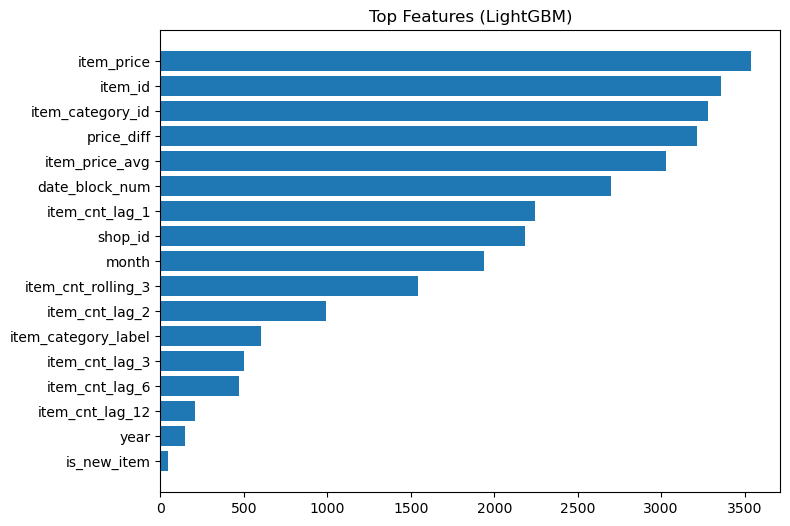

In [67]:
# STEP 9: Feature importance 

# Get feature names from booster
features = model.booster_.feature_name()
importances = model.feature_importances_

# Build dataframe
fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(30)

print(fi_df)

# Plot
plt.figure(figsize=(8,6))
plt.barh(fi_df['feature'][::-1], fi_df['importance'][::-1])
plt.title("Top Features (LightGBM)")
plt.show()

## Step 10. Build test set & submission
**Explanation**  
The test file requires predictions for **month 34**.  

We prepare features for month 34 by:
1. Taking the last available month (33) features.  
2. Shifting them to represent month 34.  
3. Merging with `test.csv` so that the final submission has exactly **214,200 rows**.  

Finally, we predict with the trained model and clip predictions between **0 and 20**, as required by competition rules.  

In [79]:
# STEP 10: Predict on test set and prepare submission

# Load test.csv
test = pd.read_csv(r"C:\Users\userr\OneDrive\Documents\predict future sales case study\test.csv")
test['date_block_num'] = 34  # Kaggle test month

# Build features from month 33
df_month33 = (
    df_final[df_final['date_block_num'] == 33]
    .groupby(['shop_id', 'item_id'])[X_train.columns.difference(['shop_id','item_id'])]
    .mean()
    .reset_index()
)
df_month33['date_block_num'] = 34  # shift to prediction month

# Merge with Kaggle test to keep all 214,200 rows
test_final = test.merge(df_month33, on=['shop_id', 'item_id', 'date_block_num'], how='left')
test_final = test_final.fillna(0)

# Ensure feature alignment
X_test = test_final[X_train.columns]

# Predict with LightGBM
y_pred_test = model.predict(X_test).clip(0, 20)

# Build submission
submission = pd.DataFrame({
    "ID": test['ID'],
    "item_cnt_month": y_pred_test
})

submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully with shape:", submission.shape)

submission.csv created successfully with shape: (214200, 2)


In [75]:
# Check first 10 rows of submission

print(submission.head(10))

   ID  item_cnt_month
0   0        2.556347
1   1        2.429550
2   2        1.291623
3   3        2.422339
4   4        2.429550
5   5        1.433902
6   6        1.897335
7   7        2.556347
8   8        2.429550
9   9        2.323808


## Final Notes
**Explanation**  
We successfully trained a **LightGBM model** and created predictions for the Kaggle competition **Predict Future Sales**.  

- The dataset was cleaned and aggregated from **daily → monthly**.  
- We engineered **lag and price features** to capture temporal patterns.  
- A **time-based validation split** was used to evaluate the model.  
- The final submission has exactly **214,200 rows**, ready to upload.  

**Possible improvements:**
- Add category-level lag features (sales per category per month).  
- Use more advanced validation such as **K-fold time series split**.  
- Hyperparameter tuning with **Optuna** or **GridSearch**.  